In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from data_parsing import load_trajectories
from functools import partial, reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from sklearn.metrics import confusion_matrix, roc_curve, auc
# from glob import glob
# import os

In [2]:
#trajectories, status = load_trajectories('data/MITxPRO+AMxB+1T2018/edges', 'data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
trajectories, status = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL', 'data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
#trajectories = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL')
#id_and_performance = pd.read_csv('data/MITxPRO-AMxB-1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance.iloc[0]
#id_and_performance

In [3]:
# node list of all students' learning pathway networks
# AM_nodelist = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
#url_id_to_url_hexname = dict(zip(AM_nodelist['order'], AM_nodelist['id']))
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
url_id_to_url_hexname = dict(zip(LaaL_nodelist['order'], LaaL_nodelist['name']))
url_id_to_url_hexname[0] = 'done with course'
def traj_to_edge_csv(traj, fname):
    edges = []
    urls = [url_id_to_url_hexname[url] for url in traj][1:-1]
    for edge in zip(urls[:-1], urls[1:]):
            # unpack those two items in the in the pair, and convert them from idex id
            edges.append(edge)
    df = pd.DataFrame(data=edges, columns = ['from', 'to'])
    df.to_csv(fname, index=False)
#traj_to_edge_csv(trajectories.iloc[0], 'test_traj')

In [4]:
#AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')


Maximum trajectory identified by number of clicks:  1699


Text(0, 0.5, 'Count of students')

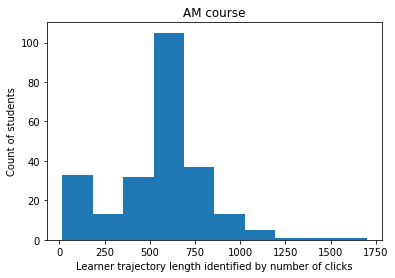

In [5]:
traj_lengths = trajectories.map(len).values
plt.hist(traj_lengths)
print("Maximum trajectory identified by number of clicks: ", max(traj_lengths))
plt.title('AM course')
plt.xlabel('Learner trajectory length identified by number of clicks')
plt.ylabel('Count of students')

## data generators 

In [6]:
index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)

incoming_traj = []
outgoing_traj = []

# this split assumes that we don't need to rebalance for unequal category weights
n_valid = int(2*np.sqrt(len(trajectories)))
n_train = len(trajectories) - n_valid
success_rate = status[index[:n_train]].sum() / n_train

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

def data_generator(start, stop, use_status):
     while True:
        for i in range(start, stop):        
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            y = outgoing_traj[index[i]].reshape(1,-1)
            if use_status:
                yield [x,s],y
            else:
                yield x,y

train_generator_simp = partial(data_generator, 0, n_train, False)
valid_generator_simp = partial(data_generator, n_train, n_train+n_valid, False)
train_generator_cond = partial(data_generator, 0, n_train, True)
valid_generator_cond = partial(data_generator, n_train, n_train+n_valid, True)
success_rate

0.06190476190476191

## Define models

In [7]:
hidden_dim = 60
embedding_dim = 30
# turning trajectories into sets of URLs
optimizer = Adam(learning_rate=0.001)
number_of_URL = max(trajectories.sum()) + 1
#number_of_URL = 1121

In [8]:
input_ = Input(shape=(None,), name='history')
embed = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(rnn)

model_simp = Model(inputs=input_, outputs=predicted_URL, name='Simple_model')
model_simp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_simp.summary()

Model: "Simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
history (InputLayer)         [(None, None)]            0         
_________________________________________________________________
URL_embedding (Embedding)    (None, None, 30)          13980     
_________________________________________________________________
LSTM (LSTM)                  (None, None, 60)          21840     
_________________________________________________________________
Predicted_URL (Dense)        (None, None, 466)         28426     
Total params: 64,246
Trainable params: 64,246
Non-trainable params: 0
_________________________________________________________________


In [9]:
input_x = Input(shape=(None,), name='history')
input_s = Input(shape=(None,), name='status')
embed_x = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_x)
embed_s = Embedding(2, hidden_dim, embeddings_initializer='ones', name='Status_embedding')(input_s)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed_x)
masked = Multiply()([rnn, embed_s])

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(masked)

model_cond = Model(inputs=[input_x, input_s], outputs=predicted_URL, name='Conditional_model')
model_cond.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_cond.summary()

Model: "Conditional_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
URL_embedding (Embedding)       (None, None, 30)     13980       history[0][0]                    
__________________________________________________________________________________________________
status (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, None, 60)     21840       URL_embedding[0][0]              
__________________________________________________________________________________

## Run models

In [10]:
#model_simp.load_weights('weights_simp.h5')
#model_cond.load_weights('AM_cond_hiddim30-.hdf5', by_name=True)

In [12]:
filepath="LaaL_cond_hiddim60-.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model_cond.fit_generator(train_generator_cond(), 
                    validation_data=valid_generator_cond(),
                    callbacks=callbacks_list,
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=100,
                    verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 210 steps, validate for 31 steps
Epoch 1/100
209/210 [============================>.] - ETA: 0s - loss: 5.0860 - acc: 0.0428
Epoch 00001: val_loss improved from inf to 4.41791, saving model to LaaL_cond_hiddim60-.hdf5
210/210 [==============================] - 54s 257ms/step - loss: 5.0838 - acc: 0.0430 - val_loss: 4.4179 - val_acc: 0.0769
Epoch 2/100
209/210 [============================>.] - ETA: 0s - loss: 3.7104 - acc: 0.1159
Epoch 00002: val_loss improved from 4.41791 to 3.22363, saving model to LaaL_cond_hiddim60-.hdf5
210/210 [==============================] - 52s 248ms/step - loss: 3.7089 - acc: 0.1162 - val_loss: 3.2236 - val_acc: 0.1641
Epoch 3/100
209/210 [============================>.] - ETA: 0s - loss: 2.7996 - acc: 0.2511
Epoch 00003: val_loss improved from 3.22363 to 2.54444, saving model to LaaL_cond_hiddim60-.hdf5
210/210 [==============================] - 53s 251ms/step - loss: 2.7994 - acc: 0.2515 - val_los

Epoch 27/100
209/210 [============================>.] - ETA: 0s - loss: 1.0619 - acc: 0.6765
Epoch 00027: val_loss improved from 1.22885 to 1.22574, saving model to LaaL_cond_hiddim60-.hdf5
210/210 [==============================] - 54s 256ms/step - loss: 1.0625 - acc: 0.6764 - val_loss: 1.2257 - val_acc: 0.6645
Epoch 28/100
209/210 [============================>.] - ETA: 0s - loss: 1.0530 - acc: 0.6782
Epoch 00028: val_loss improved from 1.22574 to 1.22332, saving model to LaaL_cond_hiddim60-.hdf5
210/210 [==============================] - 50s 240ms/step - loss: 1.0536 - acc: 0.6781 - val_loss: 1.2233 - val_acc: 0.6656
Epoch 29/100
209/210 [============================>.] - ETA: 0s - loss: 1.0464 - acc: 0.6791
Epoch 00029: val_loss improved from 1.22332 to 1.22107, saving model to LaaL_cond_hiddim60-.hdf5
210/210 [==============================] - 50s 240ms/step - loss: 1.0471 - acc: 0.6790 - val_loss: 1.2211 - val_acc: 0.6662
Epoch 30/100
209/210 [============================>.] - ET

Epoch 55/100
209/210 [============================>.] - ETA: 0s - loss: 0.9372 - acc: 0.6985
Epoch 00055: val_loss did not improve from 1.20536
210/210 [==============================] - 50s 239ms/step - loss: 0.9380 - acc: 0.6983 - val_loss: 1.2088 - val_acc: 0.6721
Epoch 56/100
209/210 [============================>.] - ETA: 0s - loss: 0.9342 - acc: 0.6994
Epoch 00056: val_loss did not improve from 1.20536
210/210 [==============================] - 50s 240ms/step - loss: 0.9349 - acc: 0.6992 - val_loss: 1.2089 - val_acc: 0.6727
Epoch 57/100
209/210 [============================>.] - ETA: 0s - loss: 0.9315 - acc: 0.6995
Epoch 00057: val_loss did not improve from 1.20536
210/210 [==============================] - 51s 243ms/step - loss: 0.9322 - acc: 0.6993 - val_loss: 1.2099 - val_acc: 0.6735
Epoch 58/100
209/210 [============================>.] - ETA: 0s - loss: 0.9284 - acc: 0.7003
Epoch 00058: val_loss did not improve from 1.20536
210/210 [==============================] - 51s 241ms

KeyboardInterrupt: 

## Sample trajectory creation 

In [14]:
proposed_traj = [0]
visit_count = defaultdict(int)
max_allowed_visits = 25

while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
    x = np.array(proposed_traj).reshape(1,-1)
    #run with s = np.ones(x.shpae) for successful
    s = np.zeros(x.shape)
    for url in reversed(np.argsort(model_cond.predict([x,s])[0,-1])):
    #for url in reversed(np.argsort(model_simp.predict(x))):
        if visit_count[url] < max_allowed_visits:
            proposed_traj.append(url)
            visit_count[url] += 1
            break
    #predicted = np.argmax(model.predict(x)[0,-1])
    print(url)
    
# print(proposed_traj)

# cert_traj = pd.DataFrame(proposed_traj)
# cert_traj.to_csv('LaaL_simp_traj_hid_dim37.csv', header = ['simple trajectory'], index = False)
traj_to_edge_csv(proposed_traj, 'MITxPRO+LASERxB1+1T2019_simulated_unsuccessful_Hdim60.csv')

1
2
3
4
5
6
7
8
9
10
11
2
12
13
14
15
17
12
18
20
18
24
22
20
28
29
31
29
34
35
36
37
38
39
40
39
40
41
39
44
45
41
47
49
46
51
53
54
55
56
50
58
59
58
59
57
63
64
61
63
64
60
41
67
71
72
73
67
75
77
78
79
80
81
74
82
85
86
84
90
88
90
67
91
94
95
96
97
98
99
91
101
103
104
105
106
107
100
109
111
108
114
116
112
120
118
120
91
121
125
126
127
121
129
131
132
133
128
135
134
137
121
139
143
144
145
139
147
149
150
151
146
153
154
155
156
158
152
158
159
160
139
164
160
164
160
165
167
165
168
169
172
173
175
169
175
177
174
179
181
179
181
178
183
182
185
169
186
188
186
190
192
189
194
196
197
198
193
200
201
202
203
199
205
186
206
207
208
207
208
206
210
212
209
214
215
216
213
218
217
220
206
221
222
221
224
227
224
226
227
223
229
231
232
233
228
235
236
237
238
239
234
241
242
221
245
246
242
250
247
256
258
259
260
251
264
266
255
268
269
261
271
242
272
275
280
272
281
283
281
284
285
288
285
291
289
293
295
292
296
299
301
302
298
304
305
285
307
305
309
311
312
313
308
317
31

## Probability estimation

In [ ]:
def score_traj(sample_traj):
    x = np.array(sample_traj[:-1]).reshape(1,-1)
    successful = np.ones(x.shape)
    unsuccessful = np.zeros(x.shape)
    cond_prob_successful = np.array(model_cond([x, successful])).reshape(-1, number_of_URL)
    cond_prob_unsuccessful = np.array(model_cond([x, unsuccessful])).reshape(-1, number_of_URL)

    score_s = []
    score_u = []

    for choice, prob_s, prob_u in zip(sample_traj[1:], cond_prob_successful, cond_prob_unsuccessful):
        score_s.append(np.log(prob_s[choice]))
        score_u.append(np.log(prob_u[choice]))
    return score_s, score_u

In [ ]:
def predict_success(traj):
    score_s, score_u = score_traj(traj)
    evidence_s = np.log(success_rate) + np.sum(score_s)
    evidence_u = np.log(1 - success_rate) + np.sum(score_u)
    prob_of_success = 1 / (1 + np.exp(evidence_u - evidence_s))
    return prob_of_success

In [ ]:
y_true = []
y_pred = []

for i in range(n_train, n_train+n_valid):
    user = index[i]
    traj = trajectories.iloc[user]
    y_true.append(status[user])
    y_pred.append(predict_success(traj))

In [ ]:
print(list(zip(y_true,y_pred)))
pd.DataFrame(confusion_matrix(y_true, np.round(y_pred)))
# columns are predictions, rows are true

In [ ]:
score_s, score_u = score_traj(trajectories.iloc[10])
score_s = np.array(score_s)
score_u = np.array(score_u)
plt.scatter(trajectories.iloc[10][1:], score_s - score_u)

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_pred)

plt.plot(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('what do we call this?')
plt.legend(loc="lower right")
plt.show()

# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
# roc_auc[i] = auc(fpr[i], tpr[i])
# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# # user list key - session level
# AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
# AM_userList

# # learning pathway network edge lists - edge list for each student in the course that represent a directed 
# # transitions networks  of students pathway through the courses content modules.  this is all students.
# AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
# AM_edgelist[:5]

In [ ]:
incoming_traj[0].shape

In [ ]:
model.predict([0,1,3,4,5,6])[0,-1].tolist()

In [ ]:
x = np.array([0,1,2,3,4,5,6]).reshape(1,-1)
s = np.zeros(x.shape)
model2.predict([x,s])[0,-1].tolist()

In [ ]:
np.argsort([7,5,1,2])

In [ ]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

In [ ]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

In [ ]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

In [ ]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data

# LaaL_edgelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

LaaL_modules = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules00.csv')
len(LaaL_modules)
LaaL_modules[460:470]

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

In [ ]:
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

In [ ]:
AM_nodelist = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

In [ ]:
LaaL_node_coord = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

In [ ]:
LaaL_id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]

count = LaaL_id_and_performance[LaaL_id_and_performance['certGrp']== 'Certified (< 65% Grade)']
len(count)